In [1]:
#import libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation, Flatten
from tensorflow.keras.models import Sequential
from math import sqrt
import math

In [2]:
Final_Data = pd.read_csv("Final_data_2_new.csv") 
Data_hour_index = Final_Data.set_index('hour')
Data_hour_index.head()
Final_Data = Final_Data.set_index('time')
Final_Data.head()

,total load actual,total load forecast,hour,weekday,month,day_of_year,day_of_month,weekdays_weekends,prev_week_load,2prev_week_load,...,humidity_Barcelona_fd_n,wind_speed_Barcelona_fd_n,temp_Valencia_fd_n,pressure_Valencia_fd_n,humidity_Valencia_fd_n,wind_speed_Valencia_fd_n,temp_Bilbao_fd_n,pressure_Bilbao_fd_n,humidity_Bilbao_fd_n,wind_speed_Bilbao_fd_n
time,,,,,,,,,,,,,,,,,,,,,
2015-01-29 00:00:00+01:00,0.696745,29143.0,0.0,0.5,0.083333,0.076503,0.903226,0,0.725466,0.679386,...,0.577628,0.052925,0.911796,0.907689,0.732581,0.455501,0.890167,0.905896,0.893859,0.162258
2015-01-29 01:00:00+01:00,0.641546,26868.0,1.0,0.5,0.083333,0.079235,0.935484,0,0.661636,0.624576,...,0.546066,0.045364,0.913751,0.908808,0.722255,0.430385,0.886338,0.907886,0.906847,0.096989
2015-01-29 02:00:00+01:00,0.609923,25463.0,2.0,0.5,0.083333,0.079235,0.935484,0,0.625990,0.591710,...,0.546069,0.004723,0.914138,0.910084,0.731997,0.490778,0.884923,0.905660,0.879407,0.133098
2015-01-29 03:00:00+01:00,0.595099,24839.0,3.0,0.5,0.083333,0.079235,0.935484,0,0.612044,0.583689,...,0.562172,0.024477,0.906960,0.909655,0.712570,0.527241,0.883615,0.907367,0.917480,0.134457
2015-01-29 04:00:00+01:00,0.592344,24629.0,4.0,0.5,0.083333,0.079235,0.935484,0,0.608363,0.579349,...,0.565704,0.016230,0.901623,0.907413,0.806337,0.134723,0.885946,0.908256,0.910870,0.122846


In [3]:
###### save information ######
#clusters after 3-mean clustering
#without decomposition
#[[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22], [0, 1, 2, 3, 4, 5, 6, 23], [7, 8, 9]]
#trend
#[[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22], [1, 2, 3, 4, 5, 6], [0, 7, 8, 23]]
#residual
#[[12, 13, 14, 15, 16, 17, 18, 21], [0, 1, 2, 3, 4, 5, 6, 22, 23], [7, 8, 9, 10, 11, 19, 20]]
#season
#[[12, 13, 14, 15, 16, 17, 18, 19, 20], [0, 1, 2, 3, 4, 5, 6, 21, 22, 23], [7, 8, 9, 10, 11]]
#tre_sea_res
#[[13, 14, 15, 16, 17, 18, 22, 23], [0, 1, 2, 3, 4, 5], [6, 7, 8, 9, 10, 11, 12, 19, 20, 21]]


In [4]:
#residual clusters
total_clusters = [[12, 13, 14, 15, 16, 17, 18, 21], [0, 1, 2, 3, 4, 5, 6, 22, 23], [7, 8, 9, 10, 11, 19, 20]]

#season
#total_clusters =[[13, 14, 15, 16, 17, 18, 22, 23], [0, 1, 2, 3, 4, 5], [6, 7, 8, 9, 10, 11, 12, 19, 20, 21]]

In [5]:
#create n different dataframes , one of any cluster, to feed n different lstms

def Dataframe_maker(Dataframe, total_clusters):
    import copy
    hours = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
    total_dataframes = []

    for cluster in total_clusters:
        for item in cluster:
            float(item)
        Dataframe['time'] = list(Dataframe.index)
        Dataframe_copy = pd.DataFrame(columns = Dataframe.columns, data = copy.deepcopy(Dataframe.values))
        Dataframe_hour = Dataframe_copy.set_index('hour')
        #find the hours not exist in cluster
        not_in_cluster = list(list(set(cluster)-set(hours)) + list(set(hours)-set(cluster)))
        total_dataframes.append(Dataframe_hour.drop(not_in_cluster))
        
        
    return total_dataframes

In [6]:
total_dataframes = Dataframe_maker(Final_Data, total_clusters)

In [7]:
#total_dataframes[2].head(10)

## Prepare input for LSTM model

In [8]:
#a function to prepare the input data for LSTM, dimension of final data is window x features.
def prepare_data_for_lstm(dataframe, first_test_day, days_of_test_set, features, label , window , horizon, black_days, hours):
    X_train = []
    X_test  = []
    Y_train = []
    Y_test  = []
    
    #date = datetime.strptime(first_test_day, "%Y-%m-%d")   #convert string to datetime
    days = [ datetime.strptime(item[:10], "%Y-%m-%d") for item in list(dataframe.index)]

    date = datetime.strptime(first_test_day, "%Y-%m-%d")   #convert string to datetime 
    id_first_test_day  = days.index(date)  #find the id of first test day in dataframe 
    
    id_first_train_day = window + black_days
    
    id_of_end = id_first_test_day + days_of_test_set * hours
    
 
            
    for i in range( id_first_train_day , id_first_test_day , hours ):
        sample = []
        for j in range( window + black_days, black_days , -1 ):
            instance = list( dataframe.iloc[i - j][features].values )
            sample.append(instance)
        X_train.append(sample)
        Y_train.append( list(dataframe.iloc[i:i+horizon][label].values) )
    
    for i in range( id_first_test_day , id_of_end , hours ):
        sample = []
        for j in range( window + black_days, black_days, -1 ):
            instance = list( dataframe.iloc[i - j][features].values )
            sample.append(instance)
        X_test.append(sample)
        Y_test.append( list(dataframe.iloc[i:i+horizon][label].values) ) 
    
    return X_train, X_test, Y_train, Y_test

In [9]:
#create X_tr, X_te, Y_tr, Y_test_real , for old model
first_test_day     = '2018-1-1'
days_of_test_set   = 365

features           = ['total load actual', 'prev_week_load_fd', '2prev_week_load_fd', '3prev_week_load_fd',
                      '4prev_week_load_fd',
                      'humidity_Madrid_fd_n','temp_Madrid_fd_n',
                     #'temp_Madrid_fd_n','pressure_Madrid_fd_n','humidity_Madrid_fd_n','wind_speed_Madrid_fd_n',
                     #'temp_Seville_fd_n','pressure_Seville_fd_n','humidity_Seville_fd_n','wind_speed_Seville_fd_n', 
                     #'temp_Barcelona_fd_n','pressure_Barcelona_fd_n','humidity_Barcelona_fd_n', 'wind_speed_Barcelona_fd_n',
                     #'temp_Valencia_fd_n','pressure_Valencia_fd_n','humidity_Valencia_fd_n', 'wind_speed_Valencia_fd_n', 
                     #'temp_Bilbao_fd_n','pressure_Bilbao_fd_n','humidity_Bilbao_fd_n', 'wind_speed_Bilbao_fd_n', 
                      'weekday_sin_fd','month_sin_fd', 'day_of_year_sin_fd', 'day_of_month_sin_fd',  
                      'weekday_cos_fd','month_cos_fd', 'day_of_year_cos_fd', 'day_of_month_cos_fd','weekdays_weekends_fd'] 

#find total y test real to make the predictions
label              = 'total load actual'
window1            = 24 * 1
horizon1            = 24
black_days1         = 24*1
X_tr, X_te, Y_tr, Y_test_real = prepare_data_for_lstm(Final_Data, first_test_day = first_test_day,
                                   days_of_test_set = days_of_test_set, features = features, label = label, 
                                   window = window1, horizon = horizon1, black_days = black_days1, hours = 24)

In [10]:
#prepare training and test data for each cluster
total_X_train = []
total_X_test  = []
total_Y_train = []
total_Y_test  = []
for i in range(0, len(total_clusters)):
    Dataframe = total_dataframes[i].set_index('time')
    hours              = len(total_clusters[i])     
    label              = 'total load actual'
    window             = hours * 1
    horizon            = hours
    black_days         = hours*1
    start_time1 = datetime.now()
    
    X_train, X_test, Y_train, Y_test = prepare_data_for_lstm(dataframe= Dataframe, first_test_day = first_test_day,
                                       days_of_test_set = days_of_test_set, features = features, label = label, 
                                       window = window, horizon = horizon, black_days = black_days, hours = hours)
    
    start_time2 = datetime.now()
    print(start_time2-start_time1)
    total_X_train.append(X_train) 
    total_X_test.append(X_test) 
    total_Y_train.append(Y_train)  
    total_Y_test.append(Y_test) 

0:00:06.174667
0:00:07.362742
0:00:05.637753


In [11]:
#create evaluation function to use them in lstms training
#create MAPE and MAE functions
def mean_absolute_percentage_error(y_true, y_pred): 
    mape=np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape
def mean_absolute_error(y_true, y_pred): 
    MAE = np.mean(np.abs(y_true-y_pred))
    return MAE
#create a function to evaluate LSTM with MAPE, MAE, RMSE, RRMSE and r2_score
def evaluation_function(y_true, y_pred):

    MAPE=mean_absolute_percentage_error(y_true, y_pred)
    print(f'MAPE: {"{:.5f}".format(MAPE)} %')
    MAE = mean_absolute_error(y_true, y_pred)
    print(f'MAE : {"{:.5f}".format(MAE)}')

    #RMSE and RRMSE
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f'RMSE: {"{:.5f}".format(rmse)}')

    RRMSE = (rmse/np.mean(y_true))*100
    print(f'RRMSE: {"{:.5f}".format(RRMSE)} % ')      
    r2 = r2_score(y_true, y_pred)
    print(f'Test R^2 score: {"{:.5f}".format(r2)}')
    
    return MAPE, MAE, rmse, RRMSE, r2
          
def yearly_error(y_true, y_pred):
    mape = []
    for i in range(0, len(y_pred)):
        for j in range(0, len(y_pred[0])):
            mape.append(mean_absolute_percentage_error(y_true[i][j],y_pred[i][j]))
    #count how many hours has error <=10%, >10% and <15%, >15% and find the percentage of every month
    count1 = 0
    count2 = 0
    count3 = 0
    for item in mape:
        if item <= 10:
            count1 += 1
        elif item <= 15:
            count2 += 1
        else :
            count3 += 1
    print('for the year')
    percentage1 =(count1*100) /(len(y_pred)*len(y_pred[0]))
    print(f'{"{:.3f}".format(percentage1)}% has error <=10')
    percentage2 =(count2*100) /(len(y_pred)*len(y_pred[0]))
    print(f'{"{:.3f}".format(percentage2)}% has error <=15')
    percentage3 =(count3*100) /(len(y_pred)*len(y_pred[0]))
    print(f'{"{:.3f}".format(percentage3)}% has error >15')
          
    return percentage1,percentage2,percentage3

### Load old model  make evaluation for each cluster

In [12]:
np.random.seed(7)
tf.random.set_seed(7)

In [13]:
old_model = keras.models.load_model('model_arch1')

In [14]:
# make a prediction and evaluation
initial_model_pred = old_model.predict(X_te)
evaluation_function(Y_test_real, initial_model_pred)
print("\n")
yearly_error(Y_test_real , initial_model_pred)
print("\n")


MAPE: 5.25232 %
MAE : 0.03706
RMSE: 0.05342
RRMSE: 7.53841 % 
Test R^2 score: 0.51809


for the year
86.107% has error <=10
7.317% has error <=15
6.575% has error >15




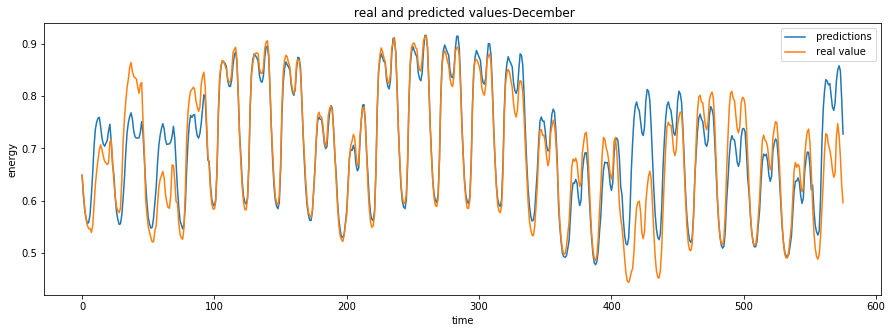

In [15]:
#plot predictions and actual values of load
#select the month 1>Jan, 2>feb, 3>Mar
Month = 12
Ytest= np.array(Y_test_real)
predictions = initial_model_pred.flatten()
actual = Ytest.flatten()

fig = plt.figure(figsize=(15,5))
plt.plot(  predictions[31*24*(Month-1):31*24*Month] ,label = " predictions" )
plt.plot(  actual[31*24*(Month-1):31*24*Month], label = " real value ")
plt.xlabel('time')
plt.ylabel('energy')
plt.title(' real and predicted values-December')
plt.legend()
plt.show()

In [16]:
#delete model 
#keras.backend.clear_session()


In [17]:
#create a function to calculate metrics by hour,
#and then use it to find metrics by cluster
def comparison_models( y_true , y_pred):
    metrics = []
    hours1 = []
    hours2 = []
    for i in range (0,24):
        temp1 = []
        temp2 = []
        for day1,day2 in zip(y_true , y_pred):
            temp1.append(day1[i])
            temp2.append(day2[i])
        hours1.append(temp1)
        hours2.append(temp2)
    count = 0
    for hour1,hour2 in zip(hours1,hours2):
        print("\n")
        print(count + 1, "Hour")
        count += 1
        
        MAPE, MAE, rmse, RRMSE, r2 = evaluation_function( np.array(hour1), np.array(hour2) ) 
        per1, per2 ,per3 = yearly_error( [hour1], [hour2] )
        temp = [ MAPE, MAE, rmse, RRMSE, r2, per1, per2 ,per3  ]
        metrics.append(temp)
    return metrics

In [18]:
metrics_by_hour_old = comparison_models(Y_test_real , initial_model_pred)



1 Hour
MAPE: 3.87518 %
MAE : 0.02399
RMSE: 0.03091
RRMSE: 4.96258 % 
Test R^2 score: 0.58256
for the year
94.247% has error <=10
4.932% has error <=15
0.822% has error >15


2 Hour
MAPE: 3.68839 %
MAE : 0.02151
RMSE: 0.02777
RRMSE: 4.71752 % 
Test R^2 score: 0.54177
for the year
96.438% has error <=10
2.466% has error <=15
1.096% has error >15


3 Hour
MAPE: 3.62231 %
MAE : 0.02040
RMSE: 0.02638
RRMSE: 4.63125 % 
Test R^2 score: 0.50245
for the year
96.164% has error <=10
2.740% has error <=15
1.096% has error >15


4 Hour
MAPE: 3.63868 %
MAE : 0.02014
RMSE: 0.02609
RRMSE: 4.65116 % 
Test R^2 score: 0.50240
for the year
94.795% has error <=10
4.384% has error <=15
0.822% has error >15


5 Hour
MAPE: 3.74999 %
MAE : 0.02084
RMSE: 0.02727
RRMSE: 4.84731 % 
Test R^2 score: 0.49844
for the year
94.247% has error <=10
4.658% has error <=15
1.096% has error >15


6 Hour
MAPE: 4.47037 %
MAE : 0.02594
RMSE: 0.03527
RRMSE: 5.99513 % 
Test R^2 score: 0.52587
for the year
88.767% has error <=10

In [19]:
#define a function to find metrics of a cluster
def cluster_evaluation(metrics_by_hour, hours):
    metrics = {"mape":0 ,"mae":0 ,"rmse":0 ,"rrmse":0 ,"r2":0,
               "<=10":0, "<=15":0, ">=15":0 }
    metrics_id = {"mape":0 ,"mae":1 ,"rmse":2 ,"rrmse":3 ,"r2":4, 
                  "<=10":5, "<=15":6, ">=15":7  }
    for hour in hours:
        for metr_id in metrics_id:
            metrics[metr_id] += metrics_by_hour[hour][metrics_id[metr_id]]
    for item in metrics:
        metrics[item] /=len(hours)
        print(item, ":", metrics[item])

In [20]:
#Cluster1 
hours = [12, 13, 14, 15, 16, 17, 18, 21] 
print('Cluster1')
cluster_evaluation(metrics_by_hour_old, hours)
#Cluster2 
hours = [0, 1, 2, 3, 4, 5, 6, 22, 23]
print('Cluster2 ')
cluster_evaluation(metrics_by_hour_old, hours)
#Cluster3
hours = [7, 8, 9, 10, 11, 19, 20]
print('Cluster2 ')
cluster_evaluation(metrics_by_hour_old, hours)

Cluster1
mape : 5.806809378828445
mae : 0.04378725392638171
rmse : 0.06011425689573825
rrmse : 7.845100630330454
r2 : 0.49434674458811223
<=10 : 82.56849315068493
<=15 : 9.212328767123289
>=15 : 8.21917808219178
Cluster2 
mape : 4.145958006157579
mae : 0.025267905657360527
rmse : 0.033564805197650344
rrmse : 5.446267030922599
r2 : 0.5433586476604175
<=10 : 92.48097412480973
<=15 : 4.961948249619483
>=15 : 2.557077625570776
Cluster2 
mape : 6.041083735733754
mae : 0.044530692141474426
rmse : 0.06347955358002728
rrmse : 8.334832801810146
r2 : 0.5127425642947411
<=10 : 81.9569471624266
<=15 : 8.180039138943249
>=15 : 9.863013698630137


### training 3 different models for each cluster

In [21]:
#save predictions in a list
total_predictions_se= []
total_metrics = []

In [22]:
### built LSTM model
keras.backend.clear_session()
np.random.seed(7)
tf.random.set_seed(7)

In [23]:
#LSTM for cluster1
def create_model1(train_set_1, horizon_1, batch_1):
    #Adaptive learning rate
    len_data_1 = len(train_set_1)
    batch_size_1 = batch_1
    baches_1 = len_data_1/batch_size_1
    boundaries_1 = [30 * baches_1, 65 * baches_1]
    values_1 = [0.005, 0.001, 0.0005]
    learning_rate_fn_1 = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries_1, values_1)
    #LSTM model
    model_1 = tf.keras.Sequential()
    model_1.add(LSTM(200, return_sequences=True, activation = 'tanh',
                   input_shape=( len(train_set_1[0]), len(train_set_1[0][0]) )))

    model_1.add(Dropout(0.4))
    model_1.add(LSTM(200, return_sequences=True))
    model_1.add(Dropout(0.4))
    
    model_1.add(LSTM(200, return_sequences=False, activation = 'tanh'))
    model_1.add(Dropout(0.3))
    #model_1.add(Dense(50, activation = 'relu'))

    model_1.add(Dense(horizon_1, activation = 'linear'))
    model_1.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate_fn_1)) 
    
    return model_1

In [24]:
batch_1 = 26
model_1 = create_model1(total_X_train[0], len(total_clusters[0]), batch_1 )

Epoch 1/100
41/41 - 2s - loss: 0.0848 - val_loss: 0.0076
Epoch 2/100
41/41 - 1s - loss: 0.0209 - val_loss: 0.0123
Epoch 3/100
41/41 - 1s - loss: 0.0161 - val_loss: 0.0093
Epoch 4/100
41/41 - 1s - loss: 0.0111 - val_loss: 0.0063
Epoch 5/100
41/41 - 1s - loss: 0.0115 - val_loss: 0.0096
Epoch 6/100
41/41 - 1s - loss: 0.0117 - val_loss: 0.0064
Epoch 7/100
41/41 - 1s - loss: 0.0089 - val_loss: 0.0056
Epoch 8/100
41/41 - 1s - loss: 0.0083 - val_loss: 0.0053
Epoch 9/100
41/41 - 1s - loss: 0.0078 - val_loss: 0.0052
Epoch 10/100
41/41 - 1s - loss: 0.0083 - val_loss: 0.0080
Epoch 11/100
41/41 - 1s - loss: 0.0100 - val_loss: 0.0127
Epoch 12/100
41/41 - 1s - loss: 0.0113 - val_loss: 0.0064
Epoch 13/100
41/41 - 1s - loss: 0.0087 - val_loss: 0.0056
Epoch 14/100
41/41 - 1s - loss: 0.0074 - val_loss: 0.0054
Epoch 15/100
41/41 - 1s - loss: 0.0070 - val_loss: 0.0051
Epoch 16/100
41/41 - 1s - loss: 0.0066 - val_loss: 0.0053
Epoch 17/100
41/41 - 1s - loss: 0.0066 - val_loss: 0.0066
Epoch 18/100
41/41 - 1s

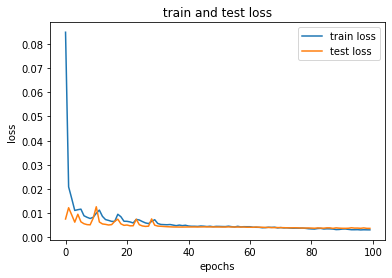

training time is:  0:01:55.098530


In [25]:
# fit network
start_time1 = datetime.now()
history = model_1.fit(total_X_train[0], total_Y_train[0], epochs= 100, batch_size=batch_1, 
                    validation_data=(total_X_test[0], total_Y_test[0]) ,verbose=2, shuffle=False)
    
#plot the losses
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title(' train and test loss ')
plt.legend()
plt.show()

start_time2 = datetime.now()
print('training time is: ', start_time2-start_time1)
    




In [26]:
#model_1 = keras.models.load_model(''model_cluster1'')

In [27]:
# make a prediction and evaluation
Y_pred_1 = model_1.predict(total_X_test[0])

MAPE, MAE, rmse, RRMSE, r2 =  evaluation_function(y_true= total_Y_test[0], y_pred= Y_pred_1)
print("\n")
per1,per2,per3 = yearly_error(y_true =total_Y_test[0] , y_pred = Y_pred_1)
print("\n")
total_metrics.append([MAPE, MAE, rmse, RRMSE, r2, per1,per2,per3])

MAPE: 5.94836 %
MAE : 0.04495
RMSE: 0.06106
RRMSE: 7.90334 % 
Test R^2 score: 0.47363


for the year
82.842% has error <=10
9.041% has error <=15
8.116% has error >15




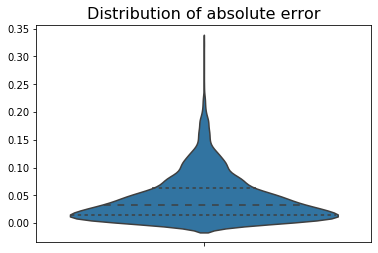

In [28]:
def violin_plot_error(error):
    ax = sns.violinplot(y=abs(error), inner='quartile')
    ax.set_title('Distribution of absolute error', fontsize=16);
#violin plot for absolute error
violin_plot_error(total_Y_test[0]- Y_pred_1)

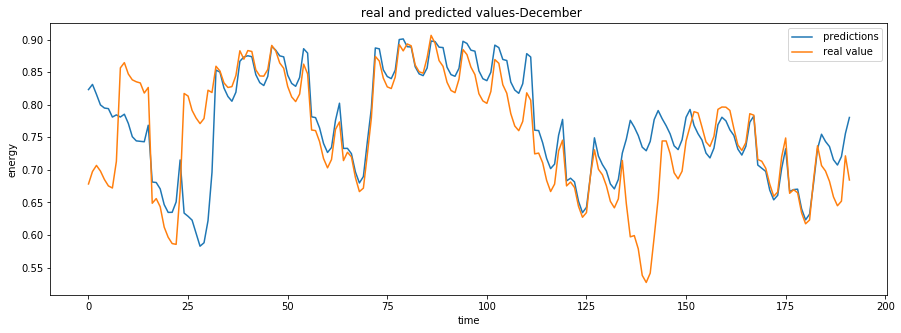

In [29]:
#plot predictions and actual values of load , for January
#select the month 1>Jan, 2>feb, 3>Mar
Month = 12
hours = len(total_Y_test[0][0])
Ytest= np.array(total_Y_test[0])
predictions = Y_pred_1.flatten()
actual = Ytest.flatten()

fig = plt.figure(figsize=(15,5))
plt.plot(  predictions[31*hours*(Month-1):31*hours*Month] ,label = " predictions" )
plt.plot(  actual[31*hours*(Month-1):31*hours*Month] , label = " real value ")
plt.xlabel('time')
plt.ylabel('energy')
plt.title(' real and predicted values-December')
plt.legend()
plt.show()

In [30]:
#model_1.save('model_cluster1')

In [31]:
total_predictions_se.append(Y_pred_1)

In [32]:
### built LSTM model
keras.backend.clear_session()
np.random.seed(7)
tf.random.set_seed(7)

In [33]:
#LSTM for cluster2
def create_model2(train_set_2, horizon_2, batch_2):
    #Adaptive learning rate
    len_data_2 = len(train_set_2)
    batch_size_2 = batch_2
    baches_2 = len_data_2/batch_size_2
    boundaries_2 = [50* baches_2, 90 * baches_2]
    values_2 = [0.005, 0.001, 0.0005]
    learning_rate_fn_2 = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries_2, values_2)
    #LSTM model
    model_2 = tf.keras.Sequential()
    model_2.add(LSTM(250, return_sequences=True, activation = 'tanh',
                   input_shape=( len(train_set_2[0]), len(train_set_2[0][0]) )))

    model_2.add(Dropout(0.3))
    #model_2.add(LSTM(200, return_sequences=True))
    #model_2.add(Dropout(0.4))
    
    model_2.add(LSTM(200, return_sequences=False, activation = 'tanh'))
    model_2.add(Dropout(0.3))
    #model_2.add(Dense(50, activation = 'relu'))

    model_2.add(Dense(horizon_2, activation = 'linear'))
    model_2.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate_fn_2)) 
    
    return model_2

In [34]:
batch_2 = 26
model_2 = create_model2(total_X_train[1], len(total_clusters[1]), batch_2)

Epoch 1/220
41/41 - 2s - loss: 0.0435 - val_loss: 0.0278
Epoch 2/220
41/41 - 1s - loss: 0.0149 - val_loss: 0.0068
Epoch 3/220
41/41 - 1s - loss: 0.0126 - val_loss: 0.0060
Epoch 4/220
41/41 - 1s - loss: 0.0069 - val_loss: 0.0023
Epoch 5/220
41/41 - 1s - loss: 0.0045 - val_loss: 0.0020
Epoch 6/220
41/41 - 1s - loss: 0.0041 - val_loss: 0.0020
Epoch 7/220
41/41 - 1s - loss: 0.0039 - val_loss: 0.0019
Epoch 8/220
41/41 - 1s - loss: 0.0035 - val_loss: 0.0018
Epoch 9/220
41/41 - 1s - loss: 0.0048 - val_loss: 0.0050
Epoch 10/220
41/41 - 1s - loss: 0.0060 - val_loss: 0.0031
Epoch 11/220
41/41 - 1s - loss: 0.0043 - val_loss: 0.0022
Epoch 12/220
41/41 - 1s - loss: 0.0034 - val_loss: 0.0019
Epoch 13/220
41/41 - 1s - loss: 0.0035 - val_loss: 0.0020
Epoch 14/220
41/41 - 1s - loss: 0.0035 - val_loss: 0.0027
Epoch 15/220
41/41 - 1s - loss: 0.0032 - val_loss: 0.0021
Epoch 16/220
41/41 - 1s - loss: 0.0040 - val_loss: 0.0026
Epoch 17/220
41/41 - 1s - loss: 0.0040 - val_loss: 0.0021
Epoch 18/220
41/41 - 1s

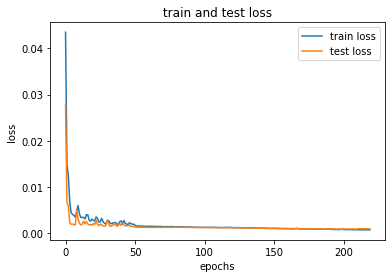

training time is:  0:04:11.996265


In [35]:
# fit network
start_time1 = datetime.now()
history = model_2.fit(total_X_train[1], total_Y_train[1], epochs= 220, batch_size=batch_2, 
                    validation_data=(total_X_test[1], total_Y_test[1]) ,verbose=2, shuffle=False)
    
#plot the losses
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title(' train and test loss ')
plt.legend()
plt.show()

start_time2 = datetime.now()
print('training time is: ', start_time2-start_time1)
    





In [36]:
#model_2 = keras.models.load_model('model_cluster2')

In [37]:
# make a prediction and evaluation
Y_pred_2 = model_2.predict(total_X_test[1])

MAPE, MAE, rmse, RRMSE, r2 = evaluation_function(y_true= total_Y_test[1], y_pred= Y_pred_2)
print("\n")
per1,per2,per3 = yearly_error(y_true =total_Y_test[1] , y_pred = Y_pred_2)
print("\n")
total_metrics.append([MAPE, MAE, rmse, RRMSE, r2, per1,per2,per3])


MAPE: 3.76995 %
MAE : 0.02311
RMSE: 0.03124
RRMSE: 5.05404 % 
Test R^2 score: 0.59795


for the year
94.368% has error <=10
3.896% has error <=15
1.735% has error >15




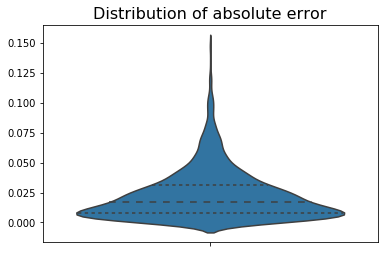

In [38]:
def violin_plot_error(error):
    ax = sns.violinplot(y=abs(error), inner='quartile')
    ax.set_title('Distribution of absolute error', fontsize=16);
#violin plot for absolute error
violin_plot_error(total_Y_test[1]- Y_pred_2)

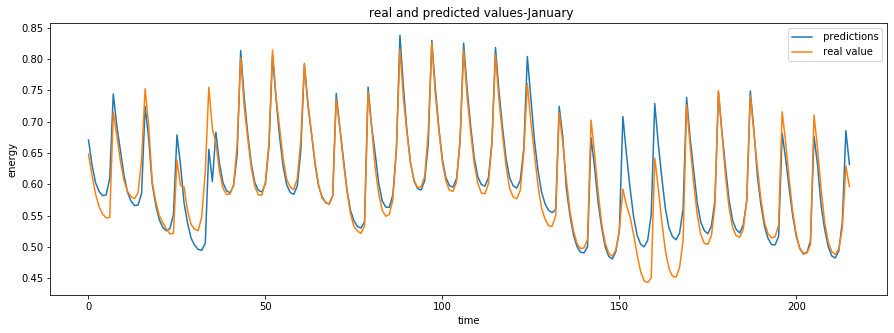

In [39]:
#plot predictions and actual values of load
#select the month 1>Jan, 2>feb, 3>Mar
Month = 12
hours = len(total_Y_test[1][0])
Ytest_2= np.array(total_Y_test[1])
predictions = Y_pred_2.flatten()
actual = Ytest_2.flatten()

fig = plt.figure(figsize=(15,5))
plt.plot(  predictions[31*hours*(Month-1):31*hours*Month],label = " predictions" )
plt.plot(  actual[31*hours*(Month-1):31*hours*Month], label = " real value ")
plt.xlabel('time')
plt.ylabel('energy')
plt.title(' real and predicted values-January')
plt.legend()
plt.show()

In [40]:
#model_2.save('model_cluster2')

In [41]:
total_predictions_se.append(Y_pred_2)

### LSTM for cluster3

In [42]:
### built 3  LSTM model
keras.backend.clear_session()
np.random.seed(7)
tf.random.set_seed(7)

In [43]:
#LSTM for cluster3
def create_model3(train_set_3, horizon_3, batch_3):
    #Adaptive learning rate
    len_data_3 = len(train_set_3)
    batch_size_3 = batch_3
    baches_3 = len_data_3/batch_size_3
    boundaries_3 = [30 * baches_3, 60 * baches_3]
    values_3 = [0.005, 0.001, 0.0005]
    learning_rate_fn_3 = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries_3, values_3)
    #LSTM model
    model_3 = tf.keras.Sequential()
    model_3.add(LSTM(200, return_sequences=True, activation = 'tanh',
                   input_shape=( len(train_set_3[0]), len(train_set_3[0][0]) )))

    model_3.add(Dropout(0.4))
    #model_3.add(LSTM(200, return_sequences=True))
    #model_3.add(Dropout(0.4))
    
    model_3.add(LSTM(200, return_sequences=False, activation = 'tanh'))
    model_3.add(Dropout(0.35))
    #model_3.add(Dense(50, activation = 'relu'))

    model_3.add(Dense(horizon_3, activation = 'linear'))
    model_3.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate_fn_3)) 
    
    return model_3

In [44]:
batch_3 = 15
model_3 = create_model3(total_X_train[2], len(total_clusters[2]), batch_3 )

Epoch 1/70
72/72 - 2s - loss: 0.0618 - val_loss: 0.0534
Epoch 2/70
72/72 - 1s - loss: 0.0260 - val_loss: 0.1417
Epoch 3/70
72/72 - 1s - loss: 0.0250 - val_loss: 0.0117
Epoch 4/70
72/72 - 1s - loss: 0.0146 - val_loss: 0.0310
Epoch 5/70
72/72 - 1s - loss: 0.0137 - val_loss: 0.0119
Epoch 6/70
72/72 - 1s - loss: 0.0139 - val_loss: 0.0340
Epoch 7/70
72/72 - 1s - loss: 0.0116 - val_loss: 0.0097
Epoch 8/70
72/72 - 1s - loss: 0.0110 - val_loss: 0.0118
Epoch 9/70
72/72 - 1s - loss: 0.0136 - val_loss: 0.0170
Epoch 10/70
72/72 - 1s - loss: 0.0125 - val_loss: 0.0325
Epoch 11/70
72/72 - 1s - loss: 0.0120 - val_loss: 0.0088
Epoch 12/70
72/72 - 1s - loss: 0.0090 - val_loss: 0.0136
Epoch 13/70
72/72 - 1s - loss: 0.0095 - val_loss: 0.0071
Epoch 14/70
72/72 - 1s - loss: 0.0089 - val_loss: 0.0086
Epoch 15/70
72/72 - 1s - loss: 0.0093 - val_loss: 0.0101
Epoch 16/70
72/72 - 1s - loss: 0.0078 - val_loss: 0.0068
Epoch 17/70
72/72 - 1s - loss: 0.0065 - val_loss: 0.0058
Epoch 18/70
72/72 - 1s - loss: 0.0060 - 

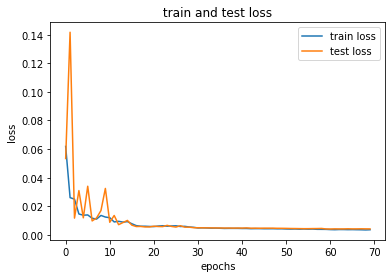

training time is:  0:01:16.466951


In [45]:
# fit network
start_time1 = datetime.now()
history = model_3.fit(total_X_train[2], total_Y_train[2], epochs= 70, batch_size=batch_3, 
                    validation_data=(total_X_test[2], total_Y_test[2]) ,verbose=2, shuffle=False)
    
#plot the losses
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title(' train and test loss ')
plt.legend()
plt.show()

start_time2 = datetime.now()
print('training time is: ', start_time2-start_time1)
    


In [46]:
#model_3 = keras.models.load_model('model_cluster3')

In [47]:
# make a prediction and evaluation
Y_pred_3 = model_3.predict(total_X_test[2])

MAPE, MAE, rmse, RRMSE, r2 =  evaluation_function(y_true= total_Y_test[2], y_pred= Y_pred_3)
print("\n")
per1,per2,per3 = yearly_error(y_true =total_Y_test[2] , y_pred = Y_pred_3)
print("\n")
total_metrics.append([MAPE, MAE, rmse, RRMSE, r2, per1,per2,per3])


MAPE: 6.40552 %
MAE : 0.04645
RMSE: 0.06458
RRMSE: 8.58647 % 
Test R^2 score: 0.52748


for the year
78.943% has error <=10
11.037% has error <=15
10.020% has error >15




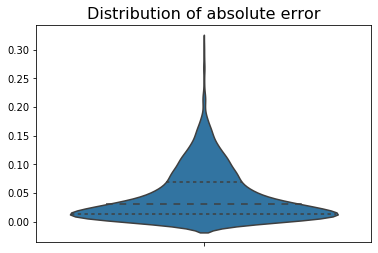

In [48]:
def violin_plot_error(error):
    ax = sns.violinplot(y=abs(error), inner='quartile')
    ax.set_title('Distribution of absolute error', fontsize=16);
#violin plot for absolute error
violin_plot_error(total_Y_test[2]- Y_pred_3)

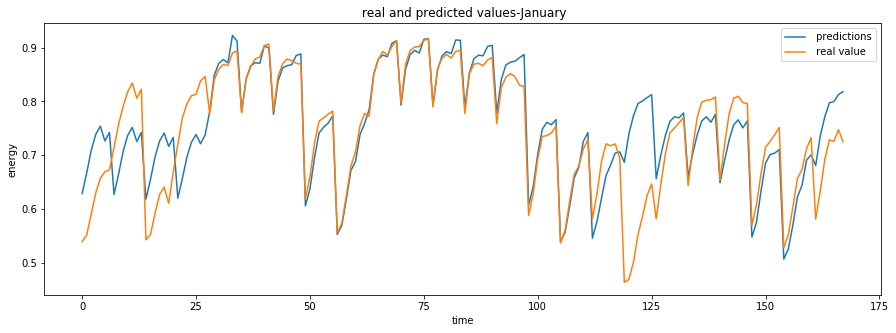

In [49]:
#plot predictions and actual values of load
#select the month 1>Jan, 2>feb, 3>Mar
Month = 12
hours = len(total_Y_test[2][0])
Ytest_3= np.array(total_Y_test[2])
predictions = Y_pred_3.flatten()
actual = Ytest_3.flatten()

fig = plt.figure(figsize=(15,5))
plt.plot(  predictions[31*hours*(Month-1):31*hours*Month],label = " predictions" )
plt.plot(  actual[31*hours*(Month-1):31*hours*Month], label = " real value ")
plt.xlabel('time')
plt.ylabel('energy')
plt.title(' real and predicted values-January')
plt.legend()
plt.show()

In [50]:
#model_3.save('model_cluster3')

In [51]:
total_predictions_se.append(Y_pred_3)

In [52]:
#calculate total metrics
def final_metrics (metrics , clusters):
    final_met = []
    for i in range(0,len(metrics[0])):
        temp = 0
        for j in range(0,len(clusters)):
            temp = temp +  metrics[j][i] * len(clusters[j])
        temp = temp /24
        final_met.append(temp)
    return final_met

In [53]:
metrics_final = final_metrics (total_metrics , total_clusters)
met = ["MAPE" , "MAE", "rmse", "RRMSE", "r2", "<=10","<=15",">15"]
for m in range(0,len(met)):
    print(met[m],metrics_final[m])

MAPE 5.264795692058932
MAE 0.037193646665842295
rmse 0.050900909413441976
RRMSE 7.034101322228859
r2 0.5359577398727234
<=10 86.02739726027397
<=15 7.69406392694064
>15 6.278538812785388


In [54]:
#concatenate and sort predictions to 24 hours list predictions and evaluate the method
def organize_hours_predictions(clusters, predictions_daily, hours):
    sort_pred=[0] * hours
    for i in range(0,len(clusters)):
        for j in range(0,len(clusters[i])):
            sort_pred[clusters[i][j]] = predictions_daily[i][j]
    
    return sort_pred


def final_predictions(clusters, total_predictions, hours):
    sorted_predictions = []
    for i in range(0,len(total_predictions[0])):
        daily_predictions = []
        for j in range(0, len(clusters)):
            daily_predictions.append(total_predictions[j][i])
        sort_pred = organize_hours_predictions(clusters, daily_predictions, hours)
        sorted_predictions.append(sort_pred)  
    
    return sorted_predictions

In [55]:
final_y_pred_se = final_predictions(total_clusters, total_predictions_se, 24)
final_y_pred_se = np.array(final_y_pred_se)
#final_y_pred.shape

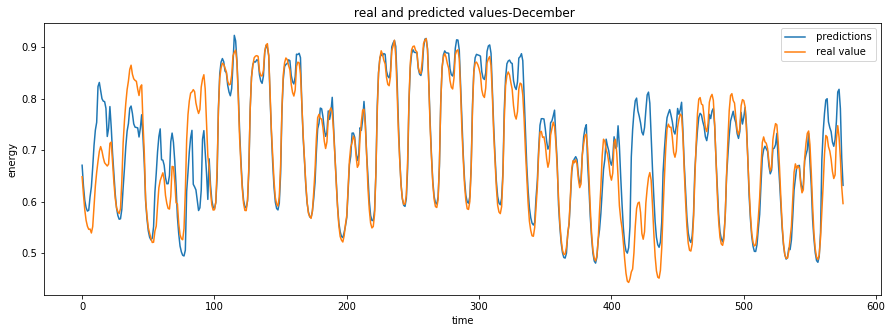

In [56]:
#plot predictions and actual values of load
#select the month 1>Jan, 2>feb, 3>Mar
Month = 12
Ytest= np.array(Y_test_real)
predictions = final_y_pred_se.flatten()
actual = Ytest.flatten()

fig = plt.figure(figsize=(15,5))
plt.plot(  predictions[31*24*(Month-1):31*24*Month] ,label = " predictions" )
plt.plot(  actual[31*24*(Month-1):31*24*Month], label = " real value ")
plt.xlabel('time')
plt.ylabel('energy')
plt.title(' real and predicted values-December')
plt.legend()
plt.show()

In [57]:
#Replace best predictions

In [58]:
#metrics by hour
def comparison_models( y_true , y_pred):
    metrics = []
    hours1 = []
    hours2 = []
    for i in range (0,24):
        temp1 = []
        temp2 = []
        for day1,day2 in zip(y_true , y_pred):
            temp1.append(day1[i])
            temp2.append(day2[i])
        hours1.append(temp1)
        hours2.append(temp2)
    count = 0
    for hour1,hour2 in zip(hours1,hours2):
        print("\n")
        print(count + 1, "Hour")
        count += 1
        
        MAPE, MAE, rmse, RRMSE, r2 = evaluation_function( np.array(hour1), np.array(hour2) ) 
        per1, per2 ,per3 = yearly_error( [hour1], [hour2] )
        temp = [ MAPE, MAE, rmse, RRMSE, r2, per1, per2 ,per3  ]
        metrics.append(temp)
    return metrics

In [59]:
metrics_by_hour_old = comparison_models(Y_test_real , initial_model_pred)
metrics_by_hour_new = comparison_models(Y_test_real, final_y_pred_se)



1 Hour
MAPE: 3.87518 %
MAE : 0.02399
RMSE: 0.03091
RRMSE: 4.96258 % 
Test R^2 score: 0.58256
for the year
94.247% has error <=10
4.932% has error <=15
0.822% has error >15


2 Hour
MAPE: 3.68839 %
MAE : 0.02151
RMSE: 0.02777
RRMSE: 4.71752 % 
Test R^2 score: 0.54177
for the year
96.438% has error <=10
2.466% has error <=15
1.096% has error >15


3 Hour
MAPE: 3.62231 %
MAE : 0.02040
RMSE: 0.02638
RRMSE: 4.63125 % 
Test R^2 score: 0.50245
for the year
96.164% has error <=10
2.740% has error <=15
1.096% has error >15


4 Hour
MAPE: 3.63868 %
MAE : 0.02014
RMSE: 0.02609
RRMSE: 4.65116 % 
Test R^2 score: 0.50240
for the year
94.795% has error <=10
4.384% has error <=15
0.822% has error >15


5 Hour
MAPE: 3.74999 %
MAE : 0.02084
RMSE: 0.02727
RRMSE: 4.84731 % 
Test R^2 score: 0.49844
for the year
94.247% has error <=10
4.658% has error <=15
1.096% has error >15


6 Hour
MAPE: 4.47037 %
MAE : 0.02594
RMSE: 0.03527
RRMSE: 5.99513 % 
Test R^2 score: 0.52587
for the year
88.767% has error <=10

In [60]:
#compare  hourly results of two models
def compare_metrics( results1 , results2 , metric):
    best_hours = []
    dictionary = {"mape":0 ,"mae":1 ,"rmse":2 ,"rrmse":3 ,"r2":4 }
    count = 0
    for metrics1,metrics2 in zip(results1,results2):
        metric1 = metrics1[dictionary[metric]]
        metric2 = metrics2[dictionary[metric]]
        if metric == "r2":
            if metric1 > metric2:
                best_hours.append(count)
        if metric1 < metric2:
            best_hours.append(count)
        count += 1
    print("The model 1 wins at:",best_hours)
    return best_hours

In [61]:
compare_metrics(metrics_by_hour_new, metrics_by_hour_old , "mape")

The model 1 wins at: [0, 1, 2, 3, 4, 5, 22, 23]


[0, 1, 2, 3, 4, 5, 22, 23]

In [62]:
#create a function to replace the better predictions from final_y_pred to y_pred
def replace_hours( y_pred,final_y_pred, hours):
    for pred1, pred2 in zip(y_pred,final_y_pred):
        for hour in hours:
            pred1[hour] = pred2[hour]
    return y_pred

In [63]:
#here we want to replace values from final_y_pred to initial_model_pred
hours =[0, 1, 2, 3, 4, 5,22, 23]
#hours = [0, 1, 2, 3, 4, 5, 17, 18, 22, 23]
replaced_pred = replace_hours( initial_model_pred,final_y_pred_se, hours)

In [64]:
evaluation_function( Y_test_real, replaced_pred) 
yearly_error( Y_test_real, replaced_pred )

MAPE: 5.18804 %
MAE : 0.03664
RMSE: 0.05317
RRMSE: 7.50264 % 
Test R^2 score: 0.52806
for the year
86.404% has error <=10
7.009% has error <=15
6.587% has error >15


(86.4041095890411, 7.0091324200913245, 6.5867579908675795)

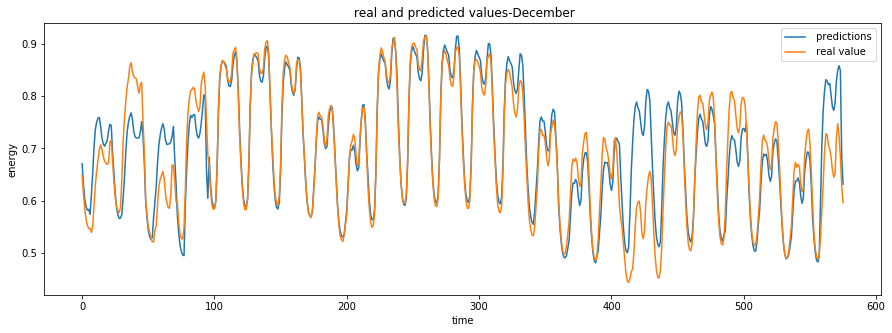

In [65]:
#plot predictions and actual values of load
#select the month 1>Jan, 2>feb, 3>Mar
Month = 12
Ytest= np.array(Y_test_real)
predictions = replaced_pred.flatten()
actual = Ytest.flatten()

fig = plt.figure(figsize=(15,5))
plt.plot(  predictions[31*24*(Month-1):31*24*Month] ,label = " predictions" )
plt.plot(  actual[31*24*(Month-1):31*24*Month], label = " real value ")
plt.xlabel('time')
plt.ylabel('energy')
plt.title(' real and predicted values-December')
plt.legend()
plt.show()